In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Question #1

# Notes
___
1. All of the dates have sufficient number of observations to resample them into 96 15-minute intervals, excluding:
* 1970-01-01 - the date when the recording is fisrt started, it has 76 intervals.
* 1970-04-13 - 76 intervals.
___

In [2]:
def load_logins_data():
    df = pd.read_json('raw_data/logins.json')
    df['logs'] = 1
    df.set_index('login_time',inplace=True)
    df = df.resample("15T").count()    
    df['date'] = df.index
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    uniqe_dates = set(df['date'])
    # strftime('%Y-%m-%d')
    # .date

    return df[['date','logs']], list(uniqe_dates)

In [3]:
logins, unique_dates = load_logins_data()

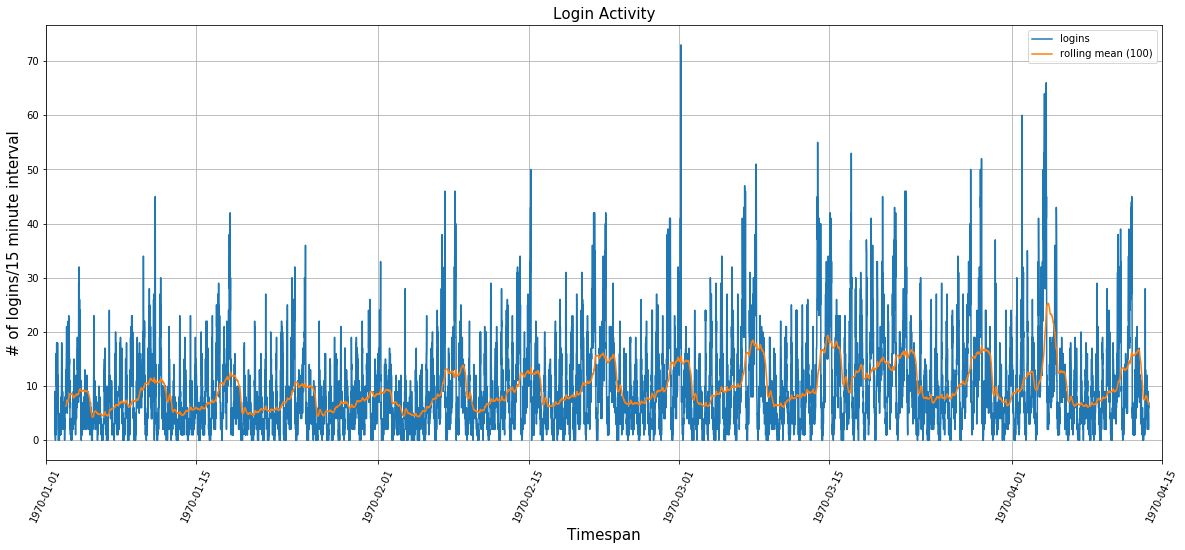

In [4]:
plt.figure(figsize=(20,8))
plt.plot(logins['logs'], label='logins')
plt.plot(logins['logs'].rolling(window=100).mean(), label='rolling mean (100)')
plt.title('Login Activity',size=15)
plt.ylabel('# of logins/15 minute interval',size=15)
plt.xlabel('Timespan',size=15)
plt.xlim([datetime.date(1970, 1, 1), datetime.date(1970, 4, 15)])
plt.xticks(rotation=65)
plt.grid()
plt.legend()
plt.show()

# Question #3

Notes: prepare testin data, see if boosting algo overfits

In [68]:
def load_ultimate_data(path):

    """
    load data, clean data, create label 
    """

    df = pd.read_json(path)

    df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(),inplace=True)
    df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(),inplace=True)
    df.phone.fillna(method='ffill',inplace=True)

    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

    # threshol to 
    threshold = pd.Timestamp('2014-06-01')
    df['retained'] = df['last_trip_date']>threshold

    return df[['city', 'signup_date', 'phone', 'trips_in_first_30_days',  'ultimate_black_user', 
'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_of_driver', 'avg_rating_by_driver', 'last_trip_date', 'retained']]
    
ultimate = load_ultimate_data('raw_data/ultimate_data_challenge.json')

In [69]:
ml_columns = ['city', 'phone', 'ultimate_black_user','trips_in_first_30_days',  'avg_surge', 'surge_pct', 'weekday_pct','avg_dist', 'avg_rating_of_driver', 'avg_rating_by_driver','retained']

In [97]:
def pre_process_data(df):

    """
    prepare data for ml
    """

    df = df[ml_columns]
    city = pd.get_dummies(df[['city']],drop_first=True)
    phone = pd.get_dummies(df[['phone']],drop_first=True)
    
    lbl_encoder = LabelEncoder()
    std_sclr = StandardScaler()
    
    ult_black = pd.DataFrame(lbl_encoder.fit_transform(ultimate[['ultimate_black_user']]),columns=['ultimate_black'])
    target = pd.DataFrame(lbl_encoder.fit_transform(ultimate[['retained']]),columns=['target'])
    

    df = pd.concat([city, phone, ult_black, ultimate[ml_columns[3:-1]], target], axis=1)
    return df

ml_ultimate = pre_process_data(ultimate)

In [98]:
X = ml_ultimate[ml_ultimate.columns[:-1]]
y = ml_ultimate[['target']]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [100]:
def scale_numerical_features(df, num_index):
    """
    df - pandas.DataFrame
    num_index - index of the df.columns where numerical features begin
    """
    num_features = df[df.columns[num_index:]]
    cat_features = df[df.columns[:num_index]]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(num_features)
    scaled_features = pd.DataFrame(scaled_features, columns=df.columns[num_index:])
    cat_features.reset_index(inplace=True,drop=True)
    

    return pd.concat([cat_features, scaled_features],axis=1)

X_train = scale_numerical_features(X_train, 4)

In [101]:
X_train

,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black,trips_in_first_30_days,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_of_driver,avg_rating_by_driver
0,0,0,1,1,-0.602400,-0.332611,-0.442224,1.050641,-0.422388,0.000383,0.493406
1,1,0,1,1,-0.074325,-0.332611,-0.442224,1.050641,5.198733,0.704140,0.493406
2,1,0,1,0,-0.602400,-0.332611,-0.442224,-1.653426,-0.801103,0.000383,0.493406
3,0,1,1,0,-0.602400,-0.332611,-0.442224,0.599062,-0.585446,0.704140,0.047415
4,1,0,1,0,0.189713,-0.332611,-0.442224,1.050641,0.513881,0.704140,0.493406
...,...,...,...,...,...,...,...,...,...,...,...
33495,0,1,0,0,-0.338362,-0.332611,-0.442224,1.050641,-0.308423,-1.062138,0.493406
33496,1,0,1,1,-0.074325,-0.332611,-0.442224,1.050641,0.671679,0.704140,0.493406
33497,0,1,0,0,-0.074325,-0.332611,-0.442224,-1.653426,-0.027892,0.704140,-0.621572
33498,0,1,1,0,-0.602400,-0.332611,-0.442224,1.050641,5.333738,0.704140,0.493406


In [102]:
xgb = GradientBoostingClassifier(n_estimators=100,max_depth=12)
xgb.fit(X_train,y_train)
xgb.score(X_train,y_train)

0.9830746268656716

In [112]:
feature_importance = pd.DataFrame({'feature': X_train.columns
,'importance':xgb.feature_importances_})

feature_importance.sort_values(['importance'],ascending=False)

,feature,importance
8,avg_dist,0.248288
10,avg_rating_by_driver,0.196016
7,weekday_pct,0.118358
0,city_King's Landing,0.082379
4,trips_in_first_30_days,0.071710
9,avg_rating_of_driver,0.070493
6,surge_pct,0.067515
2,phone_iPhone,0.048547
5,avg_surge,0.041514
3,ultimate_black,0.036151


,feature,importance
0,city_King's Landing,0.082379
1,city_Winterfell,0.019028
2,phone_iPhone,0.048547
3,ultimate_black,0.036151
4,trips_in_first_30_days,0.071710
5,avg_surge,0.041514
6,surge_pct,0.067515
7,weekday_pct,0.118358
8,avg_dist,0.248288
9,avg_rating_of_driver,0.070493
